In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

In [1]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

In [2]:
DATA_DIR = '../input/jovian-pytorch-z2g/Human protein atlas'

TRAIN_DIR = DATA_DIR + '/train'                           # Contains training images
TEST_DIR = DATA_DIR + '/test'                             # Contains test images

TRAIN_CSV = DATA_DIR + '/train.csv'                       # Contains real labels for training images
TEST_CSV = '../input/jovian-pytorch-z2g/submission.csv'   # Contains dummy labels for test image

In [3]:
!head "{TRAIN_CSV}"

Image,Label
19567,9
29993,6 4
17186,1 4
29600,6 2
701,3 4
26562,9
1080,4
27886,4
30721,6


In [4]:
!head "{TEST_CSV}"

Image,Label
24117,0
15322,0
14546,0
8079,0
13192,0
25927,0
3372,0
21781,0
2847,0


In [5]:
data_df = pd.read_csv(TRAIN_CSV)

In [6]:
data_df

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4
...,...,...
19231,428,6
19232,5342,6 7
19233,9806,4
19234,16112,5


In [7]:
test_df = pd.read_csv(TEST_CSV)

In [8]:
test_df.head()

,Image,Label
0,24117,0
1,15322,0
2,14546,0
3,8079,0
4,13192,0


In [9]:
labels = {
    0: 'Mitochondria',
1: 'Nuclear bodies',
2: 'Nucleoli',
3: 'Golgi apparatus',
4: 'Nucleoplasm',
5: 'Nucleoli fibrillar center',
6: 'Cytosol',
7: 'Plasma membrane',
8: 'Centrosome',
9: 'Nuclear speckles'
}

In [10]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)
    

In [11]:
encode_label('2 4 5')

tensor([0., 0., 1., 0., 1., 1., 0., 0., 0., 0.])

In [12]:
decode_target(torch.tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0.]))

'2 4 5'

In [13]:
decode_target(torch.tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0.]), text_labels=True)

'Nucleoli(2) Nucleoplasm(4) Nucleoli fibrillar center(5)'

In [14]:
class HumanProteinDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

In [15]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_tfms = T.Compose([
    T.RandomCrop(512, padding=8, padding_mode='reflect'),
#     T.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
#     T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.RandomHorizontalFlip(), 
    T.RandomRotation(10),
    T.ToTensor(), 
#     T.Normalize(*imagenet_stats,inplace=True), 
    T.RandomErasing(inplace=True)
])

valid_tfms = T.Compose([
#     T.Resize(256), 
    T.ToTensor(), 
#     T.Normalize(*imagenet_stats)
])

In [16]:
np.random.seed(42)
msk = np.random.rand(len(data_df)) < 0.9

train_df = data_df[msk].reset_index()
val_df = data_df[~msk].reset_index()

In [17]:
train_ds = HumanProteinDataset(train_df, TRAIN_DIR, transform=train_tfms)
val_ds = HumanProteinDataset(val_df, TRAIN_DIR, transform=valid_tfms)
len(train_ds), len(val_ds)

(17335, 1901)

In [18]:
# transform = transforms.Compose([transforms.ToTensor()])
dataset = train_ds

In [19]:
len(dataset)

17335

In [20]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))
    

Labels: Nuclear speckles(9)


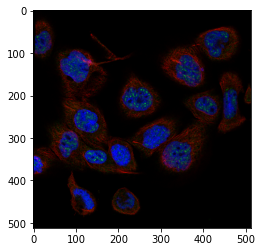

In [21]:
show_sample(*dataset[4], invert=False)

Labels: Nuclear speckles(9)


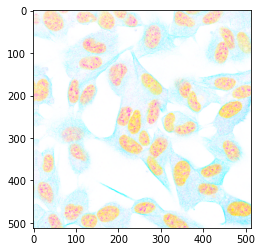

In [22]:
show_sample(*dataset[0])

In [23]:
torch.manual_seed(10)

In [24]:
# val_pct = 0.1
# val_size = int(val_pct * len(dataset))
# train_size = len(dataset) - val_size

In [25]:
# train_ds, val_ds = random_split(dataset, [train_size, val_size])
# len(train_ds), len(val_ds)

In [27]:
batch_size = 24

In [28]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [29]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

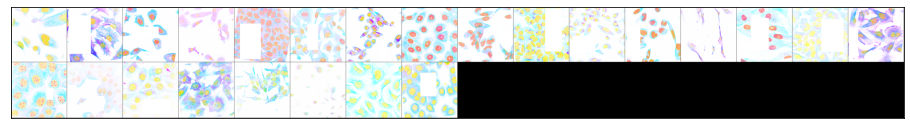

In [30]:
show_batch(train_dl)

In [31]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [32]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))

In [33]:
class ProteinCnnModel(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Sigmoid()
        )
        
    def forward(self, xb):
        return self.network(xb)

In [41]:
class ProteinCnnModel2(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [42]:
torch.cuda.empty_cache()

In [43]:
model = ProteinCnnModel2()
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


ProteinCnnModel2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [44]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [45]:
device = get_default_device()
device

device(type='cuda')

In [46]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [47]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)

images.shape: torch.Size([24, 3, 512, 512])
out.shape: torch.Size([24, 10])
out[0]: tensor([0.1936, 0.5298, 0.5853, 0.3667, 0.4340, 0.2582, 0.6221, 0.5864, 0.7158,
        0.6417], device='cuda:0', grad_fn=<SelectBackward>)


In [48]:
from tqdm.notebook import tqdm

In [49]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [50]:
model = to_device(ProteinCnnModel2(), device)

In [51]:
evaluate(model, val_dl)

{'val_loss': 0.6741305589675903, 'val_score': 0.14290392398834229}

In [52]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.01

In [53]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.3699, val_loss: 0.3637, val_score: 0.3659



Epoch [1], train_loss: 0.3411, val_loss: 0.3530, val_score: 0.2602



Epoch [2], train_loss: 0.3243, val_loss: 0.3537, val_score: 0.4049



Epoch [3], train_loss: 0.3002, val_loss: 0.4393, val_score: 0.4229



Epoch [4], train_loss: 0.2830, val_loss: 0.2749, val_score: 0.5435



Epoch [5], train_loss: 0.2654, val_loss: 0.2711, val_score: 0.5857



Epoch [6], train_loss: 0.2519, val_loss: 0.2606, val_score: 0.6134



Epoch [7], train_loss: 0.2407, val_loss: 0.2362, val_score: 0.6037



Epoch [8], train_loss: 0.2324, val_loss: 0.2341, val_score: 0.6672



Epoch [9], train_loss: 0.2256, val_loss: 0.2187, val_score: 0.6746


In [54]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.01

In [56]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.2207, val_loss: 0.2200, val_score: 0.6893



Epoch [1], train_loss: 0.2158, val_loss: 0.2177, val_score: 0.7132



Epoch [2], train_loss: 0.2121, val_loss: 0.2030, val_score: 0.7105



Epoch [3], train_loss: 0.2072, val_loss: 0.2418, val_score: 0.6594



Epoch [4], train_loss: 0.2052, val_loss: 0.2023, val_score: 0.7146



Epoch [5], train_loss: 0.2028, val_loss: 0.2089, val_score: 0.6904



Epoch [6], train_loss: 0.2002, val_loss: 0.2056, val_score: 0.7258



Epoch [7], train_loss: 0.1978, val_loss: 0.2468, val_score: 0.6712



Epoch [8], train_loss: 0.1969, val_loss: 0.1974, val_score: 0.7392



Epoch [9], train_loss: 0.1941, val_loss: 0.2020, val_score: 0.6836


In [60]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.01

In [61]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.1874, val_loss: 0.2311, val_score: 0.6726



Epoch [1], train_loss: 0.1866, val_loss: 0.2085, val_score: 0.7276



Epoch [2], train_loss: 0.1862, val_loss: 0.2062, val_score: 0.7219



Epoch [3], train_loss: 0.1854, val_loss: 0.2236, val_score: 0.7086


KeyboardInterrupt: 

In [62]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

In [63]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.1734, val_loss: 0.1831, val_score: 0.7551



Epoch [1], train_loss: 0.1689, val_loss: 0.1803, val_score: 0.7611



Epoch [2], train_loss: 0.1667, val_loss: 0.1797, val_score: 0.7606



Epoch [3], train_loss: 0.1648, val_loss: 0.1792, val_score: 0.7610



Epoch [4], train_loss: 0.1641, val_loss: 0.1790, val_score: 0.7612



Epoch [5], train_loss: 0.1643, val_loss: 0.1780, val_score: 0.7598



Epoch [6], train_loss: 0.1638, val_loss: 0.1796, val_score: 0.7612



Epoch [7], train_loss: 0.1643, val_loss: 0.1776, val_score: 0.7665



Epoch [8], train_loss: 0.1624, val_loss: 0.1779, val_score: 0.7681



Epoch [9], train_loss: 0.1623, val_loss: 0.1772, val_score: 0.7708


In [64]:
weights_fname = 'protein-resnet.pth'
torch.save(model.state_dict(), weights_fname)

In [67]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.000002

In [68]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.1596, val_loss: 0.1769, val_score: 0.7695



Epoch [1], train_loss: 0.1605, val_loss: 0.1783, val_score: 0.7694



Epoch [2], train_loss: 0.1596, val_loss: 0.1770, val_score: 0.7697



Epoch [3], train_loss: 0.1594, val_loss: 0.1777, val_score: 0.7669



Epoch [4], train_loss: 0.1600, val_loss: 0.1773, val_score: 0.7669



Epoch [5], train_loss: 0.1597, val_loss: 0.1774, val_score: 0.7699



Epoch [6], train_loss: 0.1598, val_loss: 0.1767, val_score: 0.7712



Epoch [7], train_loss: 0.1597, val_loss: 0.1782, val_score: 0.7690



Epoch [8], train_loss: 0.1597, val_loss: 0.1766, val_score: 0.7704



Epoch [9], train_loss: 0.1599, val_loss: 0.1765, val_score: 0.7699


In [69]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

In [71]:
test_dataset = HumanProteinDataset(TEST_CSV, TEST_DIR, transform=transform)

In [73]:
test_df = pd.read_csv(TEST_CSV)
test_dataset = HumanProteinDataset(test_df, TEST_DIR, transform=valid_tfms)

In [74]:
img, target = test_dataset[0]
img.shape

torch.Size([3, 512, 512])

Prediction:  tensor([2.4354e-03, 1.0555e-02, 6.5591e-02, 3.2387e-03, 9.8859e-01, 1.0629e-02,
        9.6580e-01, 5.3942e-03, 1.4520e-03, 1.4422e-04], device='cuda:0',
       grad_fn=<SelectBackward>)
Labels: Nucleoplasm(4) Cytosol(6)


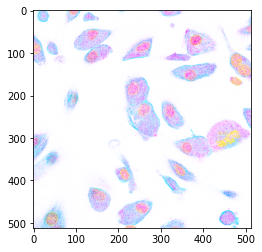

In [75]:
predict_single(test_dataset[100][0])

Prediction:  tensor([9.6902e-01, 1.1965e-03, 1.3829e-03, 5.3759e-02, 6.1836e-02, 3.1914e-04,
        2.4982e-02, 2.1738e-03, 1.2135e-02, 2.6362e-04], device='cuda:0',
       grad_fn=<SelectBackward>)
Labels: Mitochondria(0)


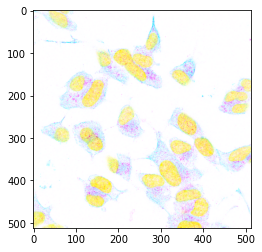

In [76]:
predict_single(test_dataset[74][0])

In [77]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True), device)

In [78]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [79]:
test_preds = predict_dl(test_dl, model)

In [80]:
submission_df = pd.read_csv(TEST_CSV)
submission_df.Label = test_preds
submission_df.head()

,Image,Label
0,24117,4
1,15322,4
2,14546,6
3,8079,6
4,13192,3 4


In [81]:
sub_fname = 'submission2.csv'

In [82]:
submission_df.to_csv(sub_fname, index=False)

In [83]:
weights_fname = 'protein-resnet.pth'
torch.save(model.state_dict(), weights_fname)

In [84]:
!pip install jovian --upgrade --quiet

In [85]:
import jovian

<IPython.core.display.Javascript object>

In [87]:
jovian.reset()
jovian.log_hyperparams(arch='resnet18', 
                       epochs=2*num_epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

NameError: name 'max_lr' is not defined

In [88]:
project_name='protein-advanced'

In [ ]:
jovian.commit(project=project_name, environment=None, outputs=[weights_fname])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/dmehta9911/protein-advanced


<IPython.core.display.Javascript object>